# Provide real demand from  data

In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import os, sys # add MaaSSim to path (not needed if MaaSSim is already in path)
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from MaaSSim.data_structures import structures as inData
from MaaSSim.utils import load_G, get_config, prep_supply
from osmnx.distance import nearest_nodes, great_circle_vec
import osmnx as ox

One day of data from our BQ for `Barcelona, Spain` and config:

In [ ]:
import pandas as pd
df = pd.read_csv("../../data/barcelona-demand.csv")
params = get_config('../../data/config/barcelona.json')  # load configuration
params.nV = 100  # and vehicle supply number
inData = load_G(inData, params)  # load city network graph 

/Users/andrzej/Personal/MaaSSim/MaSSim/lib/python3.8/site-packages/osmnx/distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)


In [ ]:
df["pickup_point"] = nearest_nodes(inData.G, df.pickup_long, df.pickup_lat)
df["dropoff_point"] = nearest_nodes(inData.G, df.dropoff_long, df.dropoff_lat)

AttributeError: 'DataFrame' object has no attribute 'pickup_long'

In [31]:
params.nP = 1000
df = df.sample(params.nP) # restrict it for demo
df.reset_index(drop=True, inplace=True)
df.head(2)

,eqr_partition_time,sqr_partition_time,quote_requested_local,correlation_id,quotes_list_id,date_scheduled_local,organisation_name,organisation_id,fleet_id,fleet_name,...,country_code,pickup_lat,pickup_long,dropoff_lat,dropoff_long,quote,quote_type,city_name,pickup_point,dropoff_point
0,2021-10-30T00:00:00Z,2021-10-30T00:00:00Z,2021-10-30T09:53:26.415Z,808cd3b5-cfb4-4be8-860d-1d3f5ce92f77,3a2bd698-3967-11ec-8e9d-1a1ba5e24c82,2021-10-31T12:00,Booking V2,d9189571-614c-4707-aea3-5c6ee5665c04,18e3f913-2f99-4fd2-afc5-58e2b89df768,Talixo,...,ES,41.304202,2.082201,41.379619,2.174844,50.82,FIXED,Barcelona,7251632804,30227084
1,2021-10-30T00:00:00Z,2021-10-30T00:00:00Z,2021-10-30T06:42:23.598Z,dd6815e4-5614-40f2-8f42-47843f9ecb63,89cc2fdc-394c-11ec-bd43-0e347aefa9fe,2021-11-06T14:00,Booking V2,d9189571-614c-4707-aea3-5c6ee5665c04,ec32e0e9-d657-49a4-8a67-6cfba65a31e0,BookTaxi,...,ES,41.304202,2.082201,41.376598,2.172704,63.00,FIXED,Barcelona,7251632804,2264150813


Mock a platforms for now (this can be different fleets in future)

In [32]:
inData.platforms.fare = [1]
inData.platforms.name = "platform_name"
inData.platforms.batch_time = 1

In [33]:
inData.passengers.pos = df["pickup_point"]
inData.passengers.platforms = [[0]] * len(inData.passengers)
inData.passengers = inData.passengers.dropna(subset=["pos"])
len(inData.passengers)

1000

In [34]:
inData.passengers

,pos,event,platforms
pax,,,
0,7251632804,NaN,[0]
1,7251632804,NaN,[0]
2,7251632804,NaN,[0]
3,2450401660,NaN,[0]
4,7251632804,NaN,[0]
...,...,...,...
995,7251632804,NaN,[0]
996,2450401660,NaN,[0]
997,7251632804,NaN,[0]


Real user positions from our quote data:

In [35]:
inData = prep_supply(inData, params)  # generate supply (mocking the vehicles)

In [36]:
inData.requests = inData.requests.dropna()

Mock requests (it can be real requests in the future)

In [37]:
inData.requests.pax_id = inData.passengers.index
inData.requests.origin = inData.passengers.pos
inData.requests.destination = df["dropoff_point"]
inData.requests.treq = pd.to_datetime(df["quote_requested_local"]).dt.tz_localize(None)
inData.requests.tarr = pd.to_datetime(df["date_scheduled_local"])
inData.requests.ttrav = pd.to_timedelta(inData.requests.tarr - inData.requests.treq)
inData.requests["platform"] = [[0]] * len(inData.passengers.index)
inData.requests["dist"] = round(great_circle_vec(df["pickup_long"], df["pickup_lat"], df["dropoff_long"], df["dropoff_lat"]))

In [38]:
inData.requests.head()

,pax_id,origin,destination,treq,tdep,ttrav,tarr,tdrop,shareable,schedule_id,platform,dist,ride_id,position,sim_schedule
0,0,7251632804,30227084,2021-10-30 09:53:26.415,NaN,1 days 02:06:33.585000,2021-10-31 12:00:00,NaN,NaN,NaN,[0],13280.0,NaN,NaN,NaN
1,1,7251632804,2264150813,2021-10-30 06:42:23.598,NaN,7 days 07:17:36.402000,2021-11-06 14:00:00,NaN,NaN,NaN,[0],12884.0,NaN,NaN,NaN
2,2,7251632804,473483353,2021-10-30 05:55:05.531,NaN,331 days 08:54:54.469000,2022-09-26 14:50:00,NaN,NaN,NaN,[0],106050.0,NaN,NaN,NaN
3,3,2450401660,1860476035,2021-10-30 13:30:36.137,NaN,2 days 23:59:23.863000,2021-11-02 13:30:00,NaN,NaN,NaN,[0],16892.0,NaN,NaN,NaN
4,4,7251632804,473483353,2021-10-30 10:07:27.654,NaN,234 days 15:12:32.346000,2022-06-22 01:20:00,NaN,NaN,NaN,[0],108145.0,NaN,NaN,NaN


In [39]:
params.nP = len(inData.requests)

In [40]:
params

DotMap(NAME='default', city='Barcelona, Spain', nP=1000, nV=100, times=DotMap(request=15, transaction=20, pickup=30, dropoff=10, patience=600, pickup_patience=90), speeds=DotMap(walk=1.2, ride=10), t0=Timestamp('2021-11-08 16:42:44'), paths=DotMap(G='../../data/graphs/Barcelona.graphml', skim='../../data/graphs/Barcelona.csv', _ipython_display_=DotMap(), _repr_mimebundle_=DotMap(), _repr_html_=DotMap(), _repr_markdown_=DotMap(), _repr_svg_=DotMap(), _repr_png_=DotMap(), _repr_pdf_=DotMap(), _repr_jpeg_=DotMap(), _repr_latex_=DotMap(), _repr_json_=DotMap(), _repr_javascript_=DotMap()), dist_threshold=100000, big_time=10, sleep=False, simTime=1, demand_structure=DotMap(origins_dispertion=-0.0003, destinations_dispertion=-0.001, temporal_dispertion=0.3, temporal_distribution='uniform'), shareability=DotMap(windows=DotMap(pickup=[-2, 5], dropoff=[-10, 5]), avg_speed=10, shared_discount=0.8, VoT=0.005, WtS=1.2, delay_value=1.5, price=1.5, matching_obj='u_veh', pax_delay=45, horizon=600, max

In [41]:
params.times.patience = 1000
params.times.pickup_patience = 1000
params.simTime = 72

In [42]:
from MaaSSim.simulators import simulate
sim = simulate(params = params, inData = inData) # simulate

08-11-21 16:43:25-WARNING-Setting up 72h simulation at 2021-10-30 00:01:31.686000 for 100 vehicles and 1000 passengers in Barcelona, Spain
08-11-21 16:43:29-INFO--------------------	Starting simulation	-------------------
08-11-21 16:43:31-INFO-pax   61  got to dest at                           2021-10-30 00:56:55.686000
08-11-21 16:43:31-INFO-pax  700  got to dest at                           2021-10-30 00:57:50.686000
08-11-21 16:43:31-INFO-pax  776  got to dest at                           2021-10-30 01:10:40.686000
08-11-21 16:43:32-INFO-pax  225  got to dest at                           2021-10-30 01:21:18.686000
08-11-21 16:43:32-INFO-pax  877  got to dest at                           2021-10-30 01:26:29.686000
08-11-21 16:43:32-INFO-pax  362  got to dest at                           2021-10-30 01:42:34.686000
08-11-21 16:43:32-INFO-pax  315  got to dest at                           2021-10-30 01:45:00.686000
08-11-21 16:43:32-INFO-pax  963  got to dest at                        

In [43]:
inData.vehicles.sample(5)

,pos,event,shift_start,shift_end,platform,expected_income
veh,,,,,,
3,2.163046e+08,driverEvent.ENDS_SHIFT,0,86400,0,NaN
29,3.024340e+07,driverEvent.ENDS_SHIFT,0,86400,0,NaN
16,2.501701e+09,driverEvent.ENDS_SHIFT,0,86400,0,NaN
50,3.024340e+07,driverEvent.ENDS_SHIFT,0,86400,0,NaN
37,5.001161e+09,driverEvent.ENDS_SHIFT,0,86400,0,NaN


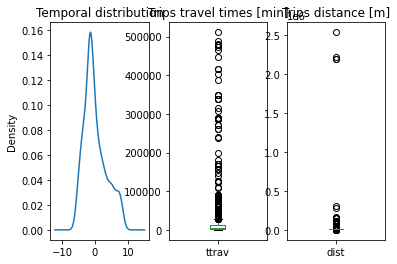

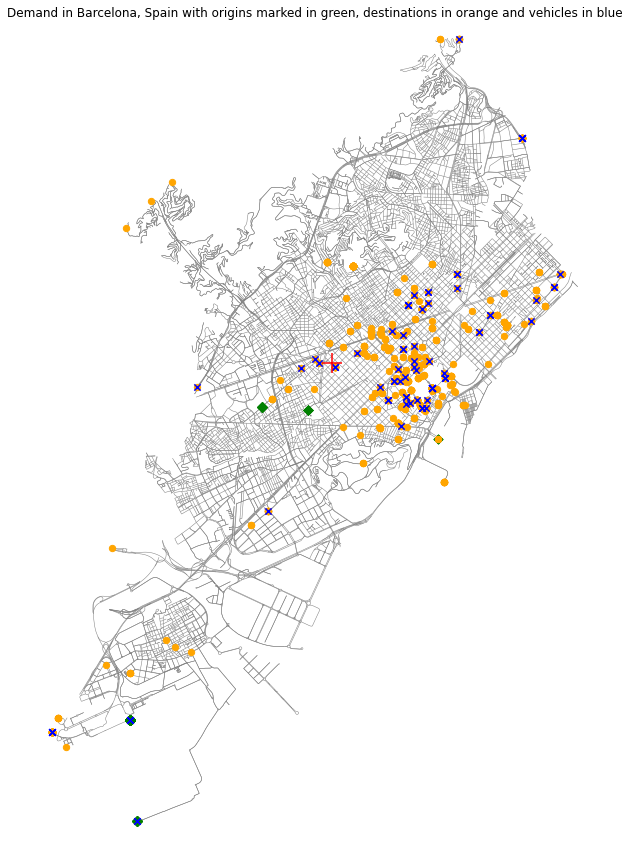

In [44]:
from MaaSSim.visualizations import plot_demand
plot_demand(inData, vehicles = True, s = 40, params = params)

In [50]:
trip_id  = 102 # we inspext traveller 6
req = sim.inData.requests[sim.inData.requests.pax_id==trip_id].squeeze() # this is his ride request
aggr = sim.res[0].pax_exp.loc[trip_id] # this is his aggregated results 
raw = sim.runs[0].trips[sim.runs[0].trips.pax == trip_id]  # this is his record within simulation
req.to_frame().T

,pax_id,origin,destination,treq,tdep,ttrav,tarr,tdrop,shareable,schedule_id,platform,dist,ride_id,position,sim_schedule
102,102,7251632804,30294473,2021-10-30 09:33:40.964,NaN,49 days 05:11:19.036000,2021-12-18 14:45:00,NaN,False,NaN,[0],10531,102,0,node time req_id od 0 ...


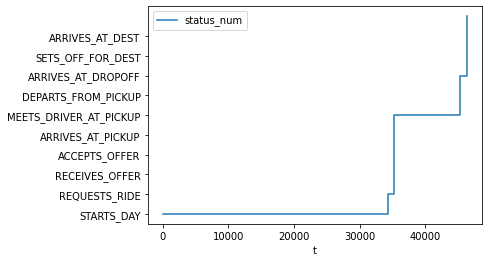

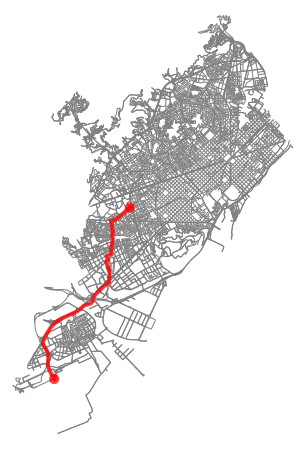

In [51]:
sim.plot_trip(trip_id)

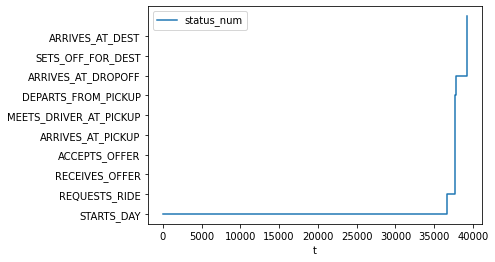

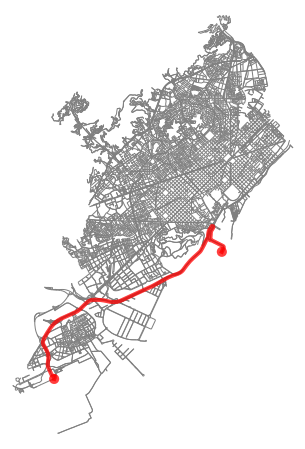

In [53]:
trip_id  = 108 # we inspext traveller 10
req = sim.inData.requests[sim.inData.requests.pax_id==trip_id].squeeze() # this is his ride request
aggr = sim.res[0].pax_exp.loc[trip_id] # this is his aggregated results 
raw = sim.runs[0].trips[sim.runs[0].trips.pax == trip_id]  # this is his record within simulation
req.to_frame().T
sim.plot_trip(trip_id)

In [54]:
from MaaSSim.utils import collect_results  # simulator
res = collect_results('hexes')

In [55]:
import folium
import json
import h3
from geojson.feature import Feature, FeatureCollection
from shapely.geometry import Point, Polygon, LineString
phantom_path = '/usr/local/bin/phantomjs'

def plot_hex_wait_vehs(inData, res, APERTURE_SIZE = 9, threshold = 3, col = 'wait_time'):
       
    traces = res.rides[['veh','pos','t']]
    diffs = traces.diff()
    diffs.columns = [_+"_diff" for _ in diffs.columns]
    traces = pd.concat([traces, diffs], axis = 1)
    trips = traces[(traces.veh_diff==0) & (traces.pos_diff==0)][['pos','t_diff']]
    trips.columns = ['pos','wait_time']
    
    trips['x'] = trips.apply(lambda row: inData.nodes.loc[row.pos].x if row.pos in inData.nodes.index else 0, axis = 1)
    trips['y'] = trips.apply(lambda row: inData.nodes.loc[row.pos].y if row.pos in inData.nodes.index else 0, axis = 1)
    trips['hex_o_{}'.format(APERTURE_SIZE)] = trips.apply(lambda row: h3.geo_to_h3(row.y,row.x,APERTURE_SIZE),axis = 1) 
    
    
    
    col_geom = 'hex_o_{}'.format(APERTURE_SIZE)
    hexes = pd.Series(list(set(list(trips[col_geom].unique())+list(trips[col_geom].unique())))).to_frame(col_geom)
    hexes = hexes.set_index(col_geom)
    hexes[col_geom] = hexes.index.copy()
    hexes['nobs'] = trips.groupby(col_geom).size()
    hexes = hexes[hexes['nobs']>threshold]
    hexes['geom'] = hexes.apply(lambda x: {"type": "Polygon","coordinates": [h3.h3_to_geo_boundary(h = x[col_geom], geo_json = True)]}, axis = 1)
    aggr = trips.groupby(col_geom)[col]
    hexes['nobs'] = aggr.size()
    hexes[col] = aggr.mean()/60
    hexes[col+'_std'] = aggr.std()
    list_features = []
    for i, row in hexes.iterrows():
        feature = Feature(geometry = row["geom"],
                          id = row[col_geom],
                          properties = {"resolution": 9})
        list_features.append(feature)

    feat_collection = FeatureCollection(list_features)
    geojson_hexes = json.dumps(feat_collection)
    CENTER = list(inData.nodes.loc[inData.stats.center][['y','x']].values)
    tile = 'cartodbpositron'
    base_map = folium.Map(location=CENTER, zoom_start=13,tiles=tile, zoomControl =  False)
    bins = [0, 1, 2, 3, 5, 10, 15, 20, 25, 115]
    m = folium.Choropleth(geo_data = geojson_hexes,data = hexes, columns = [col_geom,col],key_on ="feature.id",
            fill_color='Blues', control = False, bins = bins,
            fill_opacity=0.7, line_opacity=0.1).add_to(base_map)
    return base_map

plot_hex_wait_vehs(inData, res)

In [56]:
def plot_hex_map(inData, res, APERTURE_SIZE = 9, threshold = 3, col = 'wait_time'):
    res.requests['wait_time'] = res.requests.apply(lambda x: res.pax_exp[res.pax_exp['dt'] == x['dt']].loc[x.name].MEETS_DRIVER_AT_PICKUP, axis = 1)
    res.requests['x'] = res.requests.apply(lambda row: inData.nodes.loc[row.origin].x if row.origin in inData.nodes.index else 0 , axis = 1)
    res.requests['y'] = res.requests.apply(lambda row: inData.nodes.loc[row.origin].y if row.origin in inData.nodes.index else 0 , axis = 1)
    res.requests['hex_o_{}'.format(APERTURE_SIZE)] = res.requests.apply(lambda row: h3.geo_to_h3(row.y,row.x,APERTURE_SIZE),axis = 1) 
    trips = res.requests
    
    col_geom = 'hex_o_{}'.format(APERTURE_SIZE)
    hexes = pd.Series(list(set(list(trips[col_geom].unique())+list(trips[col_geom].unique())))).to_frame(col_geom)
    hexes = hexes.set_index(col_geom)
    hexes[col_geom] = hexes.index.copy()
    hexes['nobs'] = trips.groupby(col_geom).size()
    hexes = hexes[hexes['nobs']>threshold]
    hexes['geom'] = hexes.apply(lambda x: {"type": "Polygon","coordinates": [h3.h3_to_geo_boundary(h = x[col_geom], geo_json = True)]}, axis = 1)
    aggr = trips.groupby(col_geom)[col]
    hexes['nobs'] = aggr.size()
    hexes[col] = aggr.mean()/60
    hexes[col+'_std'] = aggr.std()
    list_features = []
    for i, row in hexes.iterrows():
        feature = Feature(geometry = row["geom"],
                          id = row[col_geom],
                          properties = {"resolution": 9})
        list_features.append(feature)

    feat_collection = FeatureCollection(list_features)
    geojson_hexes = json.dumps(feat_collection)
    CENTER = list(inData.nodes.loc[inData.stats.center][['y','x']].values)
    tile = 'cartodbpositron'
    base_map = folium.Map(location=CENTER, zoom_start=13,tiles=tile, zoomControl =  False)
    bins = [0, 1, 2, 3, 5, 10, 15, 20, 25, 114]
    m = folium.Choropleth(geo_data = geojson_hexes,data = hexes, columns = [col_geom,col],key_on ="feature.id",
            fill_color='Blues', control = False, bins = bins,
            fill_opacity=0.7, line_opacity=0.1).add_to(base_map)
    return base_map
    
plot_hex_map(inData, res, APERTURE_SIZE = 9)

In [26]:
def plot_hex_map(inData, res, APERTURE_SIZE = 9, threshold = 3, col = 'wait_time'):
    res.requests['wait_time'] = res.requests.apply(lambda x: res.pax_exp[res.pax_exp['dt'] == x['dt']].loc[x.name].MEETS_DRIVER_AT_PICKUP, axis = 1)
    res.requests['x'] = res.requests.apply(lambda row: inData.nodes.loc[row.origin].x if row.origin in inData.nodes.index else 0 , axis = 1)
    res.requests['y'] = res.requests.apply(lambda row: inData.nodes.loc[row.origin].y if row.origin in inData.nodes.index else 0 , axis = 1)
    res.requests['hex_o_{}'.format(APERTURE_SIZE)] = res.requests.apply(lambda row: h3.geo_to_h3(row.y,row.x,APERTURE_SIZE),axis = 1) 
    trips = res.requests
    
    col_geom = 'hex_o_{}'.format(APERTURE_SIZE)
    hexes = pd.Series(list(set(list(trips[col_geom].unique())+list(trips[col_geom].unique())))).to_frame(col_geom)
    hexes = hexes.set_index(col_geom)
    hexes[col_geom] = hexes.index.copy()
    hexes['nobs'] = trips.groupby(col_geom).size()
    hexes = hexes[hexes['nobs']>threshold]
    hexes['geom'] = hexes.apply(lambda x: {"type": "Polygon","coordinates": [h3.h3_to_geo_boundary(h = x[col_geom], geo_json = True)]}, axis = 1)
    aggr = trips.groupby(col_geom)[col]
    hexes['nobs'] = aggr.size()
    hexes[col] = aggr.mean()/60
    hexes[col+'_std'] = aggr.std()
    list_features = []
    for i, row in hexes.iterrows():
        feature = Feature(geometry = row["geom"],
                          id = row[col_geom],
                          properties = {"resolution": 9})
        list_features.append(feature)

    feat_collection = FeatureCollection(list_features)
    geojson_hexes = json.dumps(feat_collection)
    CENTER = list(inData.nodes.loc[inData.stats.center][['y','x']].values)
    tile = 'cartodbpositron'
    base_map = folium.Map(location=CENTER, zoom_start=13,tiles=tile, zoomControl =  False)
    bins = [0, 1, 2, 3, 5, 10, 15, 20, 25, 114]
    m = folium.Choropleth(geo_data = geojson_hexes,data = hexes, columns = [col_geom,col],key_on ="feature.id",
            fill_color='Blues', control = False, bins = bins,
            fill_opacity=0.7, line_opacity=0.1).add_to(base_map)
    return base_map
    
plot_hex_map(inData, res, APERTURE_SIZE = 9)